<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>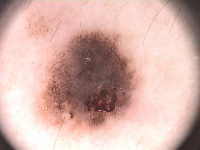</td><td>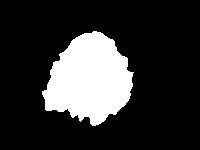</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
import gc
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на  256×256  пикселей. Для изменения размера изображений можно использовать skimage.transform.resize(). Эта функция также автоматически нормализует изображения в диапазоне  [0,1]

In [2]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


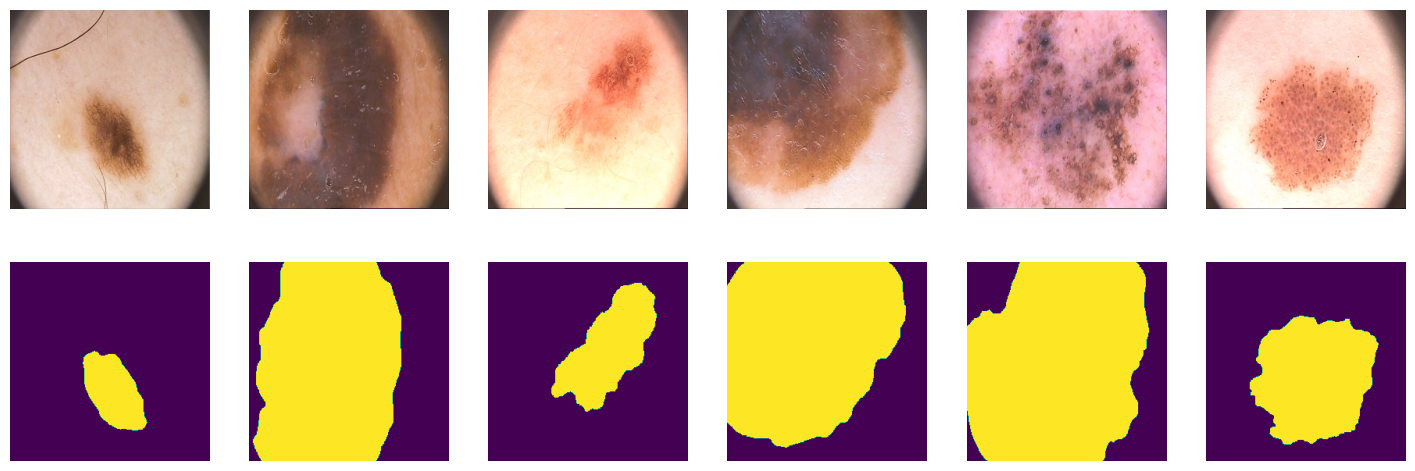

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [5]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [6]:
print(len(tr), len(val), len(ts))

100 50 50


In [7]:
from torch.utils.data import DataLoader
batch_size = 17
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [8]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------
# SegNet [2 балла]

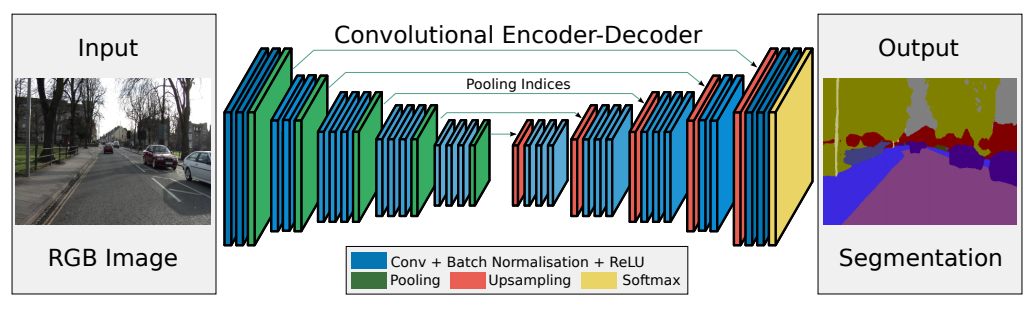
* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [10]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.enc_conv0 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                        nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)       ,
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                        nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True)
                        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True, padding=0, dilation=1, ceil_mode=False) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                        nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                        nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                        nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True)
                        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True, padding=0, dilation=1, ceil_mode=False) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                        nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True)
                        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True, padding=0, dilation=1, ceil_mode=False) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                        nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True)
                        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True, padding=0, dilation=1, ceil_mode=False) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.ReLU(inplace=True)
                            )
        #self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        #decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(2,2)# 16 -> 32
        self.dec_conv0 = nn.Sequential(
                        nn.Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True) 
                        )
        self.upsample1 = nn.MaxUnpool2d(2,2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                        nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True) 
                        )
        self.upsample2 = nn.MaxUnpool2d(2,2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                        nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True) 
                        )
        self.upsample3 = nn.MaxUnpool2d(2,2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                        nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1) ),
                        nn.BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.ReLU(inplace=True) 
                        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0( self.enc_conv0(x) )
        e1, ind1 = self.pool1( self.enc_conv1(e0) )
        e2, ind2 = self.pool2( self.enc_conv2(e1) )
        e3, ind3 = self.pool3( self.enc_conv3(e2) )

       # bottleneck
        b = self.bottleneck_conv(e3)
        
        
        # decoder
        d0 = self.dec_conv0( self.upsample0(b, ind3) )
        d1 = self.dec_conv1( self.upsample1(d0, ind2) )
        d2 = self.dec_conv2( self.upsample2(d1, ind1) )
        d3 = self.dec_conv3( self.upsample3(d2, ind0) )
        
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.
TP / TP + FP + FN(???)



Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [11]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    eps = 1e-8 #Если вдург что-то окажется нулём, то мы сможем разделить это 
    intersection = (outputs & labels).float().sum((1, 2))  # Intersection
    union = (outputs | labels).float().sum((1, 2))         # Union

    iou = (intersection + eps) / (union + eps)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return iou

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:
f.nn.sigmoid_cross_entropy_with_logits
$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [12]:
def bce_loss(y_pred, y_real): #y_real is labels[0, 1], y_pred is model output
    return ( y_pred - y_real*y_pred + torch.log(1 + torch.exp((-1)*y_pred)) ).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [13]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    
    losses = {'train': [], 'val' : []}
    metricks = {'train': [], 'val' : []}
    
    
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_iou = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            if torch.cuda.is_available():
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
            
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            Y_hat = torch.where(F.sigmoid(Y_pred)>0.5, 1 , 0 )
            loss =  loss_fn(Y_pred, Y_batch)# forward-pass
            iou = iou_pytorch(Y_hat, Y_batch)
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            avg_iou += iou.mean() / len(data_tr)
        toc = time()
        losses['train'].append(avg_loss.item())
        metricks['train'].append(avg_iou.item())
        print('Train loss: %f' % avg_loss)
        print('Train IoU: %f' % avg_iou)
        
        # show intermediate results
        avg_loss = 0
        avg_iou = 0
        model.eval()# testing mode
        for X_batch, Y_batch in data_val:
            if torch.cuda.is_available():
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
            with torch.no_grad():
                Y_pred = model(X_batch)
            Y_hat = torch.where(F.sigmoid(Y_pred)>0.5, 1 , 0 )
            loss = loss_fn(Y_pred, Y_batch)
            iou = iou_pytorch(Y_hat, Y_batch)
            Y_hat = Y_hat.cpu().numpy()
            avg_loss += loss / len(data_val)
            avg_iou += iou.mean() / len(data_val)
        losses['val'].append(avg_loss.item())
        metricks['val'].append(avg_iou.item())   
        print('Val loss: %f' % avg_loss)
        print('Val IoU: %f' % avg_iou)
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
    return losses, metricks
        

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [14]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ model(X_batch) for X_batch, _ in data]
    return np.array(Y_pred)

In [15]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_hat = torch.where(F.sigmoid(Y_pred)>0.5, 1 , 0 )
        scores += metric(Y_hat, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [16]:
from torch.optim import Adam, RMSprop, Adagrad, Adadelta

torch.cuda.empty_cache()
gc.collect()

model = SegNet().to(device)

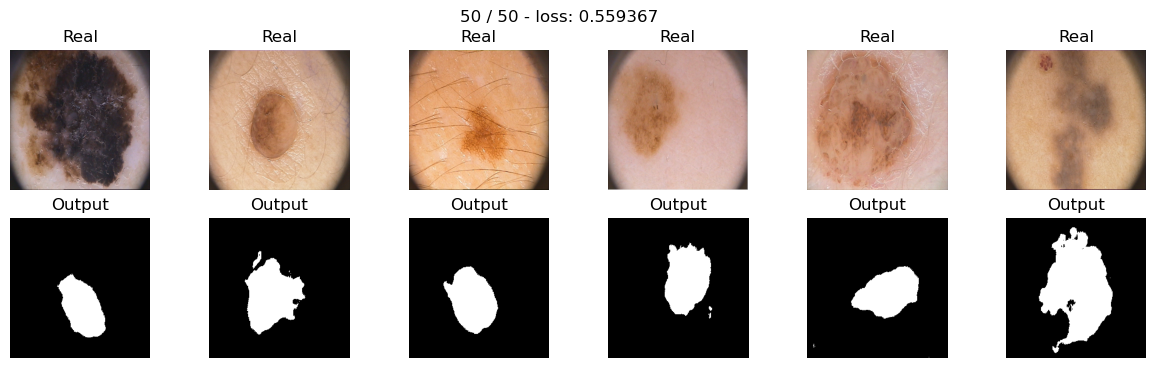

In [17]:
max_epochs = 50
optim = Adam(model.parameters(), lr=3e-4)
seg_losses1, seg_metricks1 = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

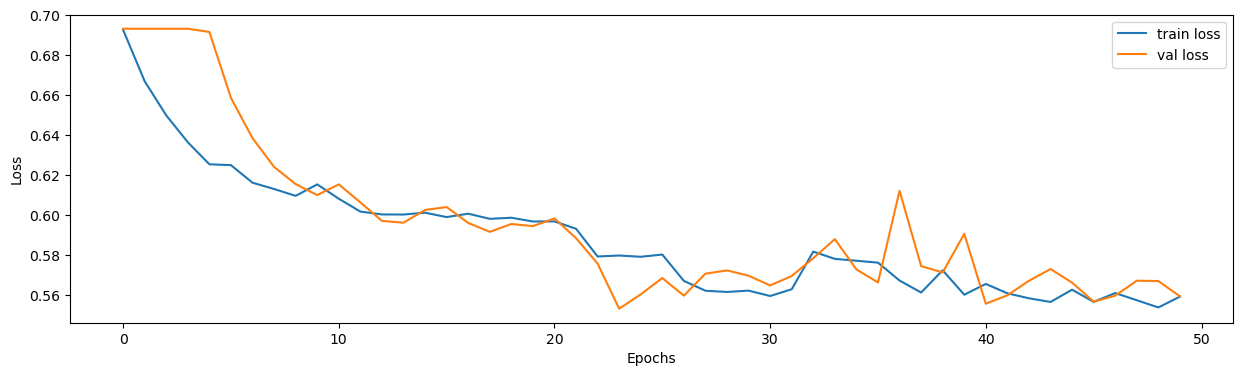

In [18]:
plt.plot(seg_losses1['train'])
plt.plot(seg_losses1['val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train loss','val loss'])

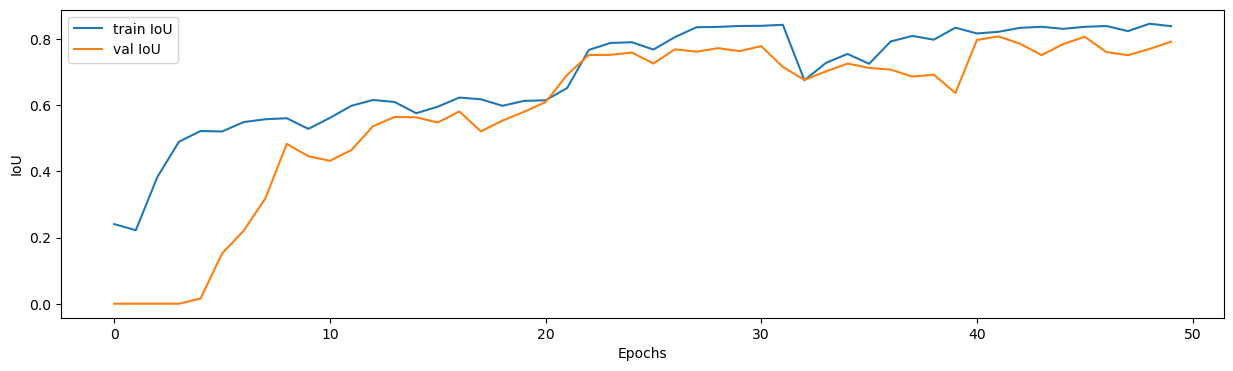

In [19]:
plt.plot(seg_metricks1['train'])
plt.plot(seg_metricks1['val'])
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(['train IoU','val IoU'])

In [20]:
# Оценка качества модели на Test выборке
score_model(model, iou_pytorch, data_ts)

0.7818266550699869

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$
Где $|..|$ означает кол-во элементов маски.
Эта функция не является дифференцируемой, но это необходимое свойство 
для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [21]:
def dice_loss(y_real, y_pred, epsilon = 1e-8):    
    #y = y_pred.sigmoid()
    
    num  = (2 * (y_pred * y_real).sum() + epsilon)     
    den  = (y_pred + y_real).sum() + epsilon    
    return 1 - (num / den)

In [22]:
torch.cuda.empty_cache()
gc.collect()

46678

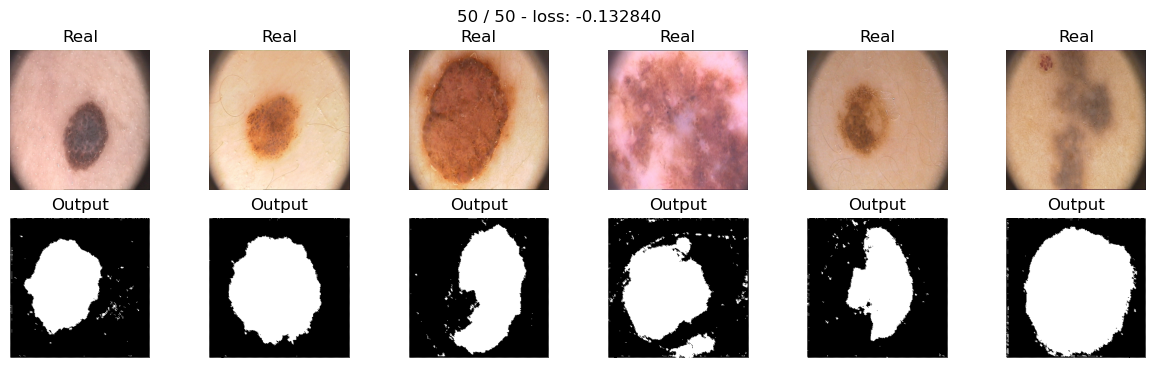

In [23]:
model_dice = SegNet().to(device)

max_epochs = 50
optimizer = Adam(model_dice.parameters(), lr=3e-4)
seg_losses2, seg_metricks2 = train(model_dice, optimizer, dice_loss, max_epochs, data_tr, data_val)

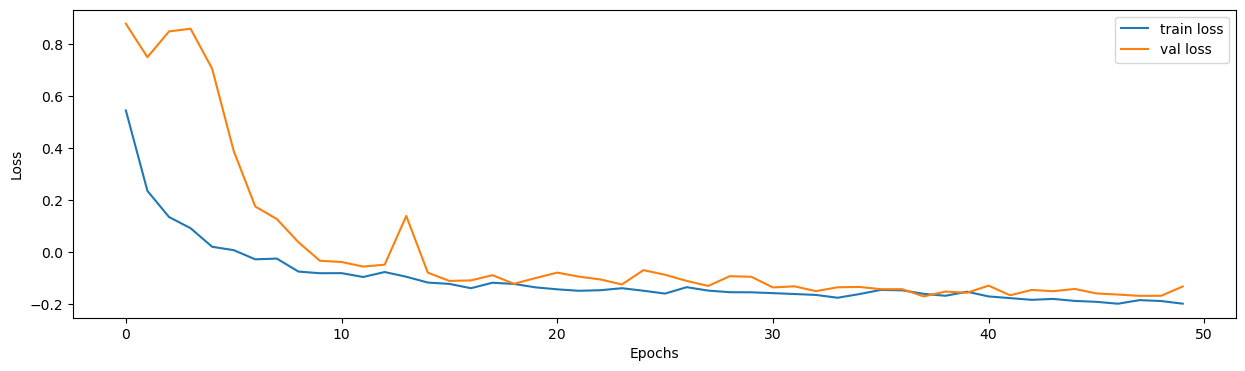

In [24]:
plt.plot(seg_losses2['train'])
plt.plot(seg_losses2['val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train loss','val loss'])

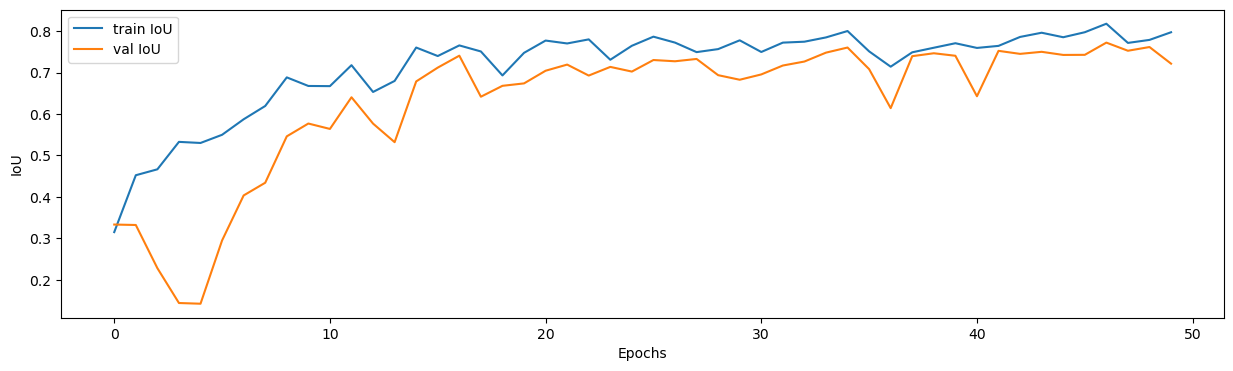

In [25]:
plt.plot(seg_metricks2['train'])
plt.plot(seg_metricks2['val'])
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(['train IoU','val IoU'])

In [26]:
# Оценка качества модели на Test выборке
score_model(model_dice, iou_pytorch, data_ts)

0.7267403602600098

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, который взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [27]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = F.sigmoid(y_pred)
    loss =(-1)*( ( (1 - y_pred)**gamma )*y_real*torch.log(y_pred) + (1 - y_real)*torch.log(1 - y_pred) ).mean() 
    return loss

In [28]:
torch.cuda.empty_cache()
gc.collect()

23358

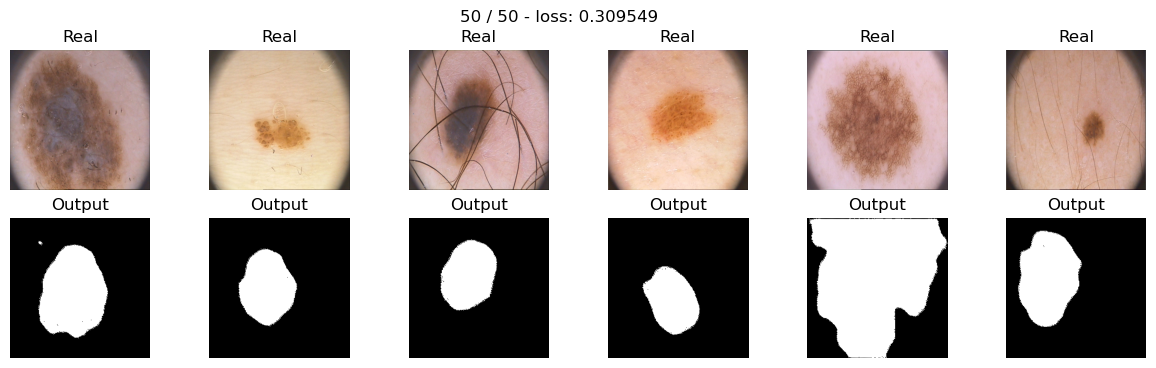

In [29]:
model_focal = SegNet().to(device)

max_epochs = 50
optimizer = Adam(model_focal.parameters(), lr=1e-4)
seg_losses3, seg_metricks3 = train(model_focal, optimizer, focal_loss, max_epochs, data_tr, data_val)

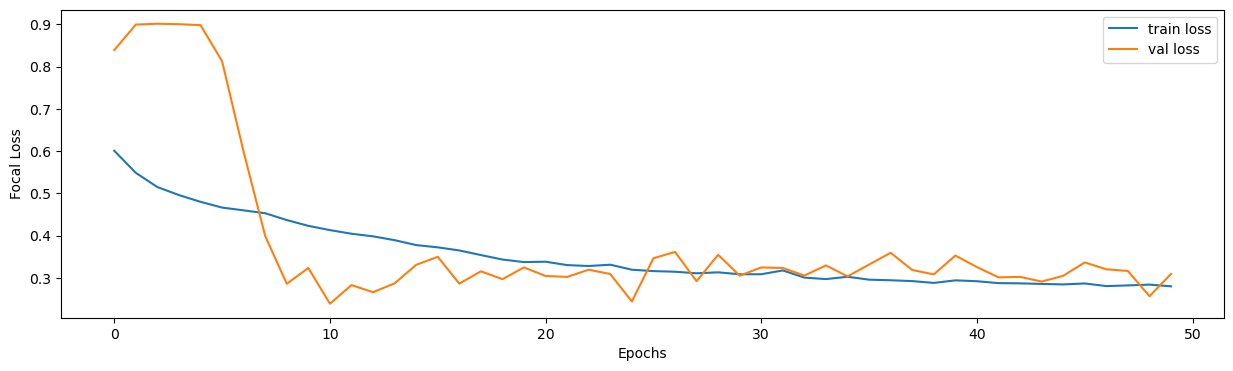

In [30]:
plt.plot(seg_losses3['train'])
plt.plot(seg_losses3['val'])
plt.xlabel('Epochs')
plt.ylabel('Focal Loss')
plt.legend(['train loss','val loss'])

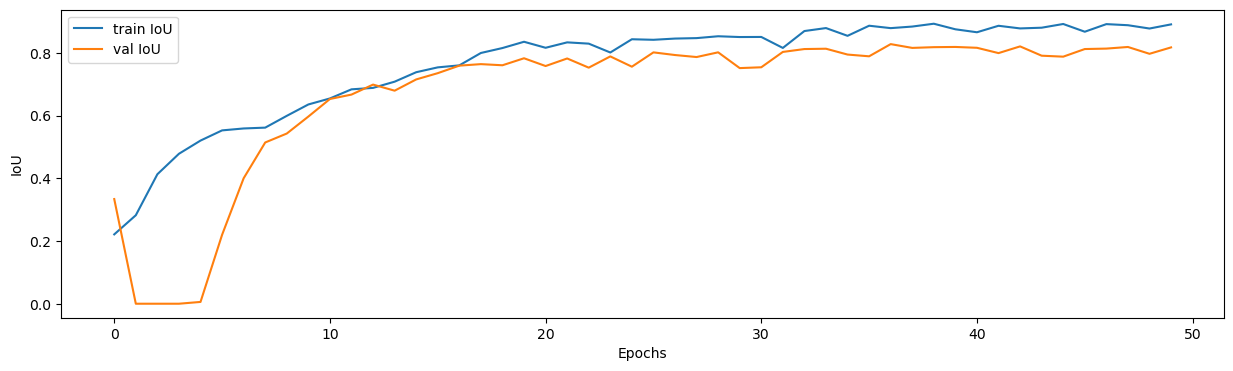

In [31]:
plt.plot(seg_metricks3['train'])
plt.plot(seg_metricks3['val'])
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(['train IoU','val IoU'])

In [32]:
# Оценка качества модели на Test выборке
score_model(model_focal, iou_pytorch, data_ts)

0.8436235785484314

# Вывод: 
    Модель показала ещё более качественное обучение, loss вышел на плато 
        начиная с 20ой эпохи.
    Данный вариант лосса оказался самым продуктивным с точки
        зрения IoU на test set    

<!-- ----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее. -->

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

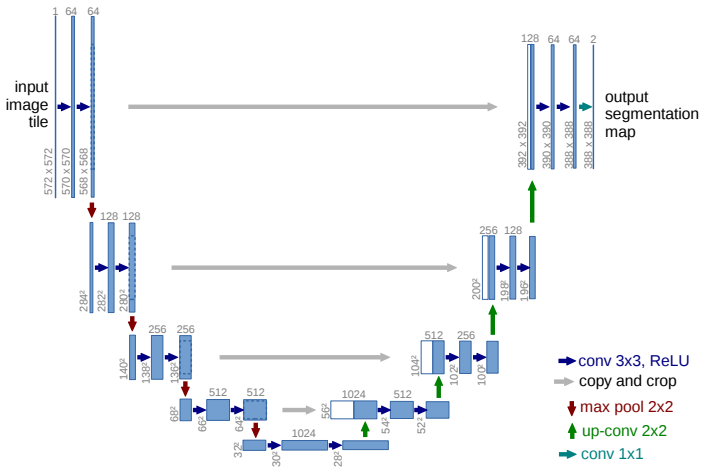

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [33]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),    
                    nn.Conv2d(64, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 
        self.enc_conv1 = nn.Sequential(
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),    
                    nn.Conv2d(128, 128, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                    nn.Conv2d(128, 256, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),    
                    nn.Conv2d(256, 256, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                    nn.Conv2d(256, 512, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),    
                    nn.Conv2d(512, 512, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        #bottleneck
        self.bottleneck_conv = nn.Sequential(
                    nn.Conv2d(512, 512, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),    
                    nn.Conv2d(512, 512, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.upconv0 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_conv0 = nn.Sequential(
                    nn.Conv2d(512, 256, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(256, 256, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.upconv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_conv1 = nn.Sequential(
                    nn.Conv2d(256, 128, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 128, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.upconv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Sequential(
                    nn.Conv2d(128, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(64, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                    nn.Conv2d(128, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(64, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(64, 1, kernel_size=3, padding=1),
                    )

    def forward(self, x):
        # encoder
        x_after_conv = self.enc_conv0(x)
        e0, ind0 = self.pool0( x_after_conv ) 
        e1, ind1 = self.pool1( self.enc_conv1(e0) )
        e2, ind2 = self.pool2( self.enc_conv2(e1) )
        e3, ind3 = self.pool3( self.enc_conv3(e2) )

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(torch.concat((e2, self.upconv0( self.upsample0(b, ind3) ) ),1) )
        d1 = self.dec_conv1(torch.concat((e1, self.upconv1( self.upsample1(d0, ind2) ) ),1) )
        d2 = self.dec_conv2(torch.concat((e0, self.upconv2( self.upsample2(d1, ind1) ) ),1) )
        d3 = self.dec_conv3(torch.concat((x_after_conv, self.upsample3(d2, ind0) ),1) ) 
        #d3 = self.dec_conv3( self.upsample3(d2, ind0) )
        return d3 #SIZE Batchx1x256x256 

In [34]:
torch.cuda.empty_cache()
gc.collect()

70023

In [35]:
unet_model = UNet().to(device)
max_epochs = 50
optimizer = Adam(unet_model.parameters(), lr=3e-4)

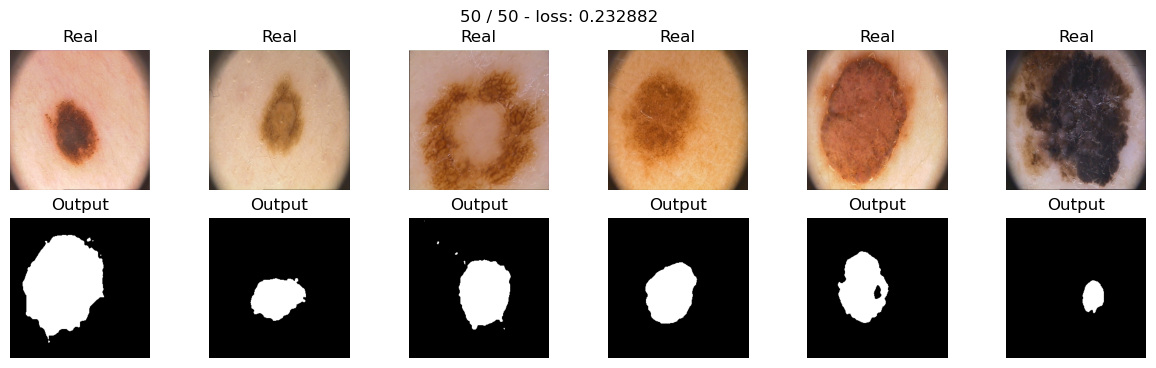

In [36]:
unet_losses1, unet_metricks1 = train(unet_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

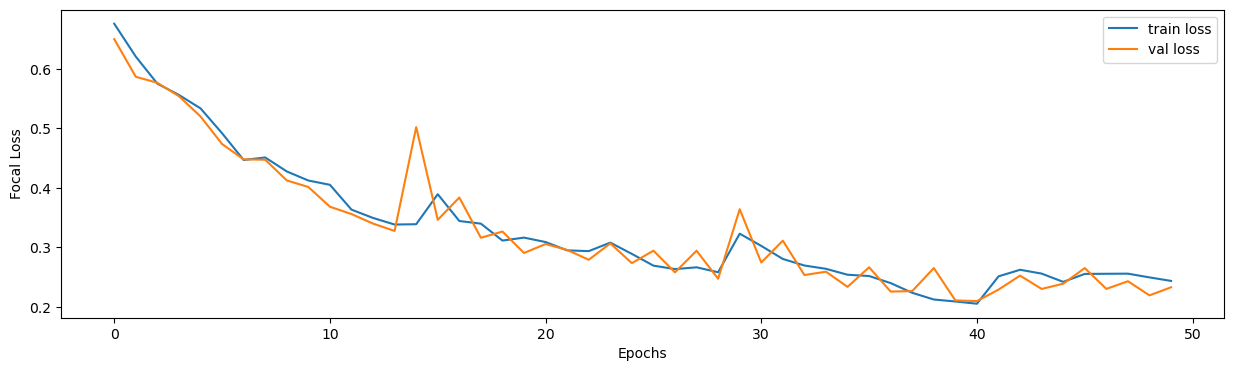

In [37]:
plt.plot(unet_losses1['train'])
plt.plot(unet_losses1['val'])
plt.xlabel('Epochs')
plt.ylabel('Focal Loss')
plt.legend(['train loss','val loss'])

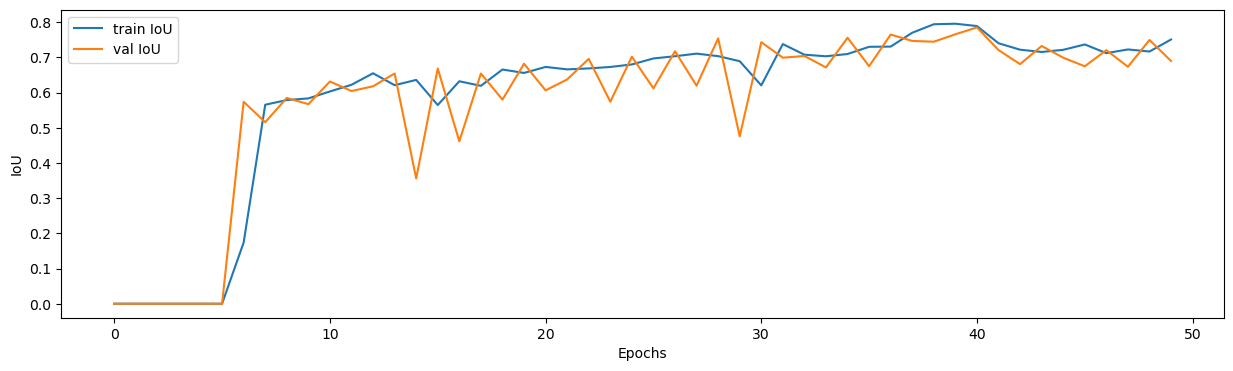

In [38]:
plt.plot(unet_metricks1['train'])
plt.plot(unet_metricks1['val'])
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(['train IoU','val IoU'])

In [39]:
# Оценка качества модели на Test выборке
score_model(unet_model, iou_pytorch, data_ts)

0.7186801632245382

# Вывод:
    Модель продемострировала хорошее обучение, показатели train и val всегда
        были рядом друг с другом, переобучение не обнаружено.
    После 50 эпох модель показала скор = 0.75, однако, в отличие от дургих 
        моделей, нельзя сказать что она вышла на плато к этому моменту
         => у нее был потенциал для развития.

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.

In [40]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
                    nn.Conv2d(3, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),    
                    nn.Conv2d(64, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.pool0 = nn.MaxPool2d(3, 2, padding=1) #256 -> 128
        self.enc_conv1 = nn.Sequential(
                    nn.Conv2d(64, 128, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),    
                    nn.Conv2d(128, 128, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                    nn.Conv2d(128, 256, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),    
                    nn.Conv2d(256, 256, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.pool2 = nn.MaxPool2d(3, 2, padding=1) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                    nn.Conv2d(256, 512, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),    
                    nn.Conv2d(512, 512, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.pool3 = nn.MaxPool2d(3, 2, padding=1) # 32 -> 16

#         #bottleneck
        self.bottleneck_conv = nn.Sequential(
                    nn.Conv2d(512, 512, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),    
                    nn.Conv2d(512, 512, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32) # 16 -> 32
        self.upconv0 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_conv0 = nn.Sequential(
                    nn.Conv2d(512, 256, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(256, 256, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.upsample1 = nn.Upsample(64) # 32 -> 64
        self.upconv1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_conv1 = nn.Sequential(
                    nn.Conv2d(256, 128, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(128, 128, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.upconv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_conv2 = nn.Sequential(
                    nn.Conv2d(128, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(64, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True)
                    )
        self.upsample3 = nn.Upsample(256) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                    nn.Conv2d(128, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(64, 64, kernel_size=3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(64, 1, kernel_size=3, padding=1),
                    )

    def forward(self, x):
        # encoder
        x_after_conv = self.enc_conv0(x)
        e0 = self.pool0( x_after_conv ) 
        e1 = self.pool1( self.enc_conv1(e0) )
        e2 = self.pool2( self.enc_conv2(e1) )
        e3 = self.pool3( self.enc_conv3(e2) )

        # bottleneck
        b = self.bottleneck_conv(e3)

#         # decoder
        e4 = self.upsample0(b)
        d0 = self.dec_conv0(torch.concat((e2, self.upconv0( self.upsample0(b) ) ),1) )
        d1 = self.dec_conv1(torch.concat((e1, self.upconv1( self.upsample1(d0) ) ),1) )
        d2 = self.dec_conv2(torch.concat((e0, self.upconv2( self.upsample2(d1) ) ),1) )
        d3 = self.dec_conv3(torch.concat((x_after_conv, self.upsample3(d2) ),1) ) 
           
        return d3 #SIZE Batchx1x256x256 
    

In [41]:
torch.cuda.empty_cache()
gc.collect()

70011

In [42]:
unet2_model = UNet2().to(device)

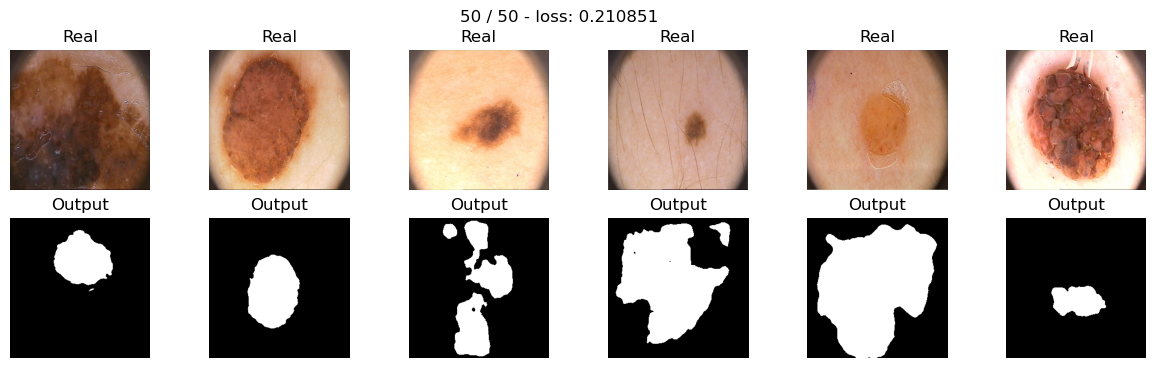

In [43]:
max_epochs = 50
optimizer = Adam(unet2_model.parameters(), lr=3e-4)
unet_losses2, unet_metricks2 = train(unet2_model, optimizer, bce_loss, max_epochs, data_tr, data_val)

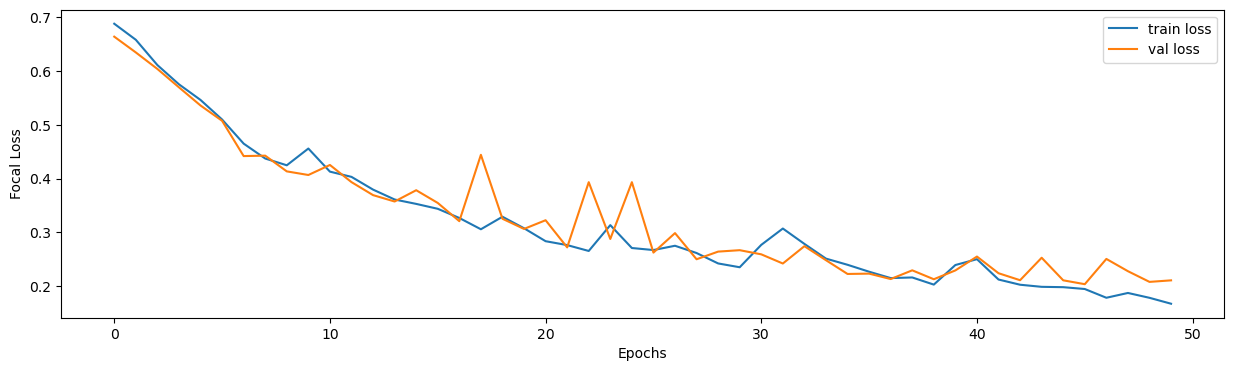

In [44]:
plt.plot(unet_losses2['train'])
plt.plot(unet_losses2['val'])
plt.xlabel('Epochs')
plt.ylabel('Focal Loss')
plt.legend(['train loss','val loss'])

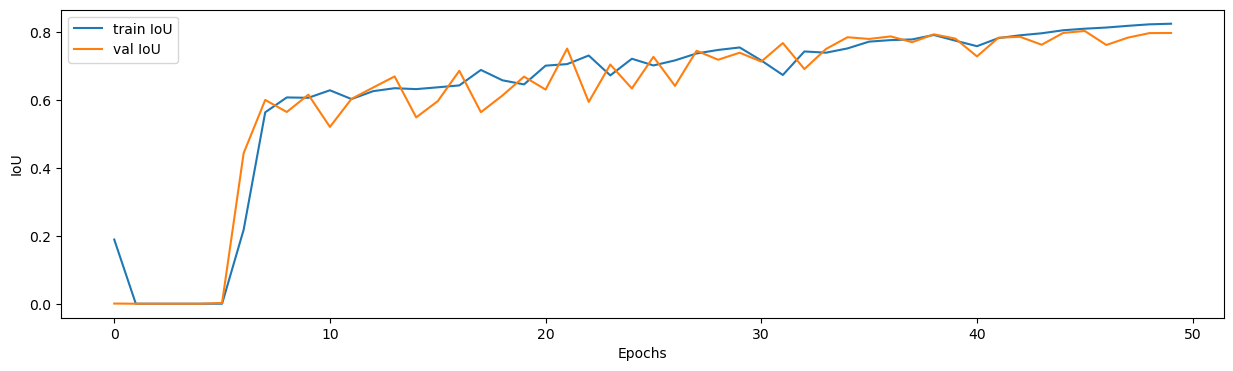

In [45]:
plt.plot(unet_metricks2['train'])
plt.plot(unet_metricks2['val'])
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(['train IoU','val IoU'])

In [46]:
# Оценка качества модели на Test выборке
score_model(unet2_model, iou_pytorch, data_ts)

0.8027180631955465

Сделайте вывод, какая из моделей лучше

-- Лучший результат получился на SegNet с Focal Loss функцией.(IoU = 0.84)

Отчет (6 баллов):
Ниже предлагается написать отчет о проделанной работе и построить графики для лоссов, метрик на валидации и тесте. Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.

Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.

Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

# Оценим поведение метрики IoU моделей на Val выборке

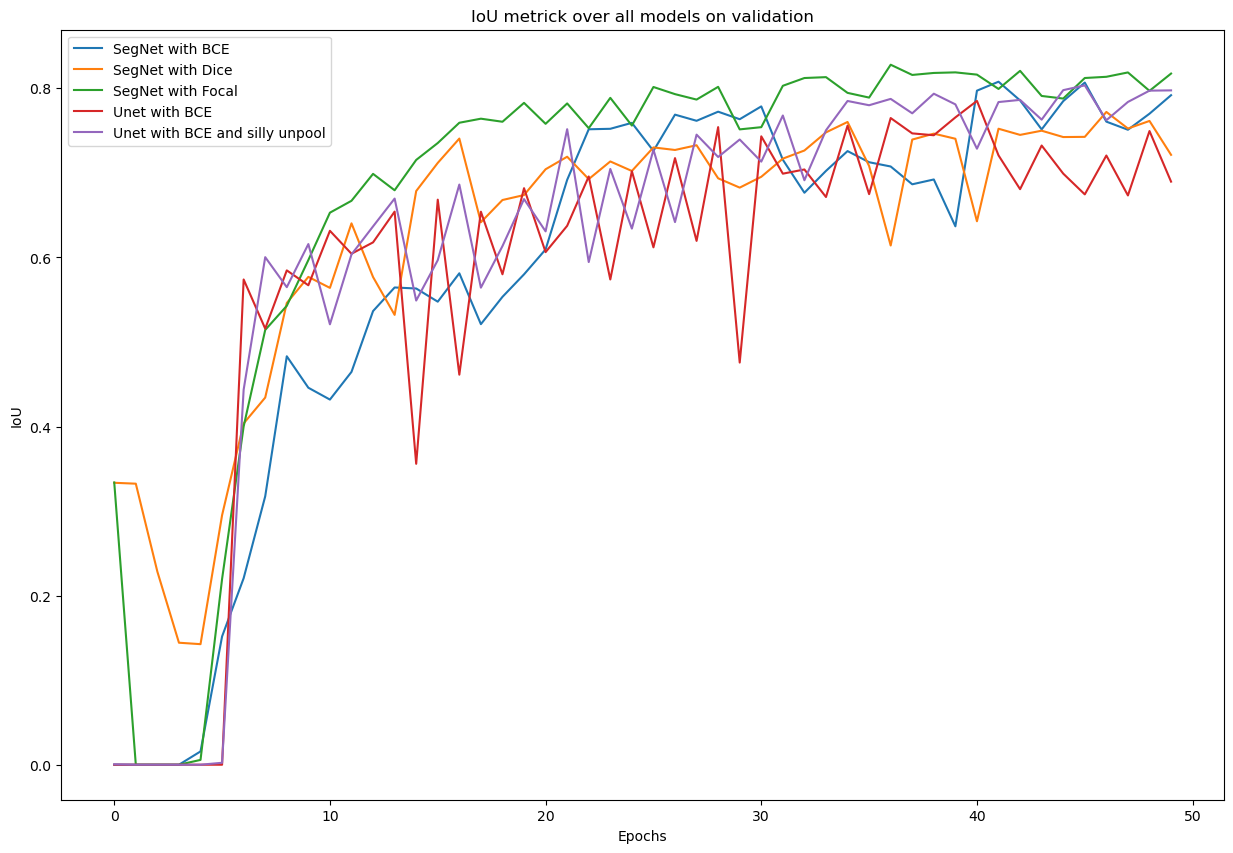

In [101]:
plt.figure(figsize=(15, 10))
plt.plot(seg_metricks1['val'])
plt.plot(seg_metricks2['val'])
plt.plot(seg_metricks3['val'])
plt.plot(unet_metricks1['val'])
plt.plot(unet_metricks2['val'])
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(['SegNet with BCE','SegNet with Dice',
            'SegNet with Focal','Unet with BCE','Unet with BCE and silly unpool'])
plt.title('IoU metrick over all models on validation')
plt.show()

# Вывод:
    Как мы можем наблюдать, наиболее качественной моделью оказался SegNet
        оптимизированный на Focal Loss. Причем качество модели заключается не 
        только в высоком скоре, но также в гармонично растущей метрике IoU без
        явных скачков и аномальных значний. 
    Посмотрим побробнее на эту модель, оценим как она училась, не было ли 
        переобучения и успела ли она выйти на плато :

### Оценим поведение Loss функции SegNet with Focal Loss:

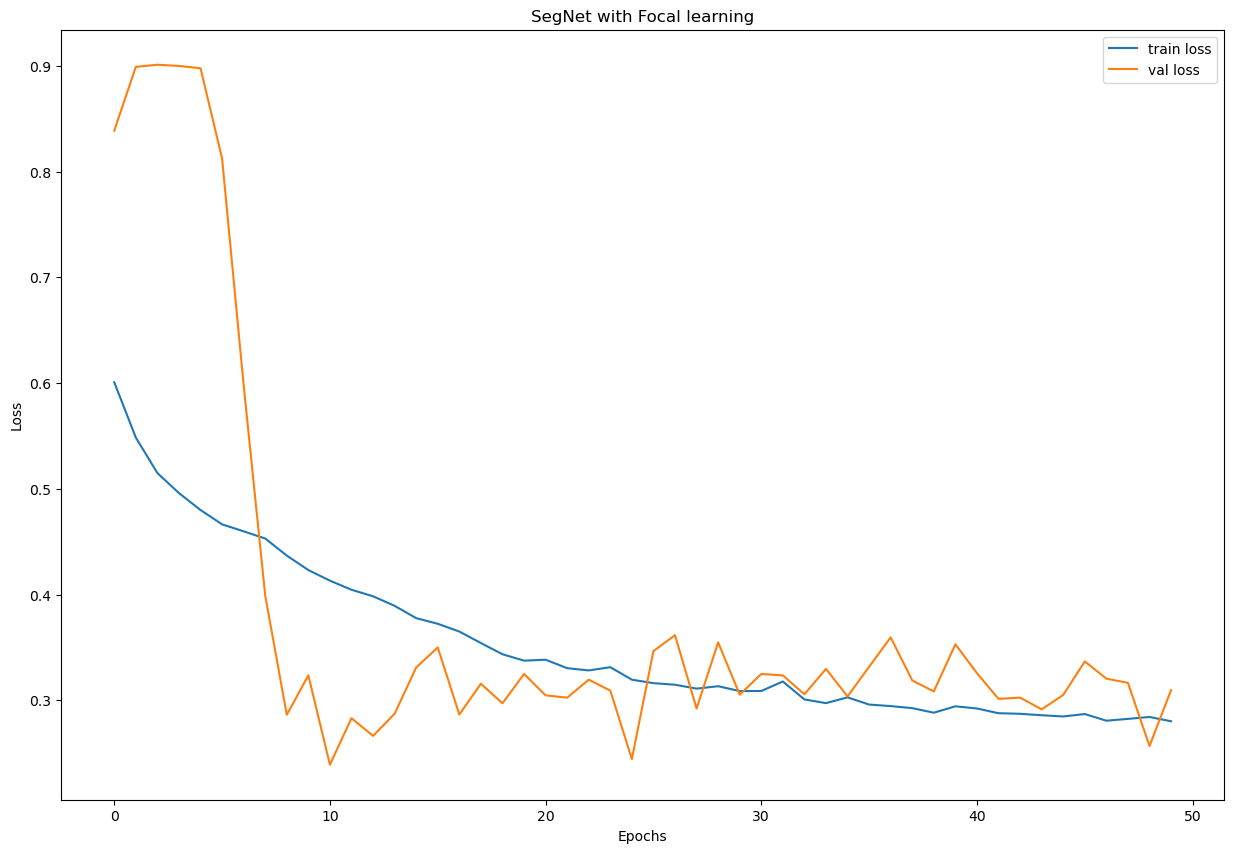

In [104]:
plt.figure(figsize=(15, 10))
plt.plot(seg_losses3['train'])
plt.plot(seg_losses3['val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train loss','val loss'])
plt.title('SegNet with Focal learning')
plt.show()

# Вывод:
    Как мы видим, переобучения нет, начиная с 10ой эпохи кривые
        лосса на train и val выборках примерно выровнялись 
        и идут рядом друг с дружкой.
    Также следует отметить, что loss не вышел на плато за 50 эпох, 
        а следовательно имело бы смысл дообучить модель еще и 
        вероятно повысить ее качество. В рамках моей работы все
        исследуемые модели находились в равных услвиях,
        поэтому для чистоты их сравнения я решил осталовиться на 50 эпохах

### Оценим поведение метрики IoU

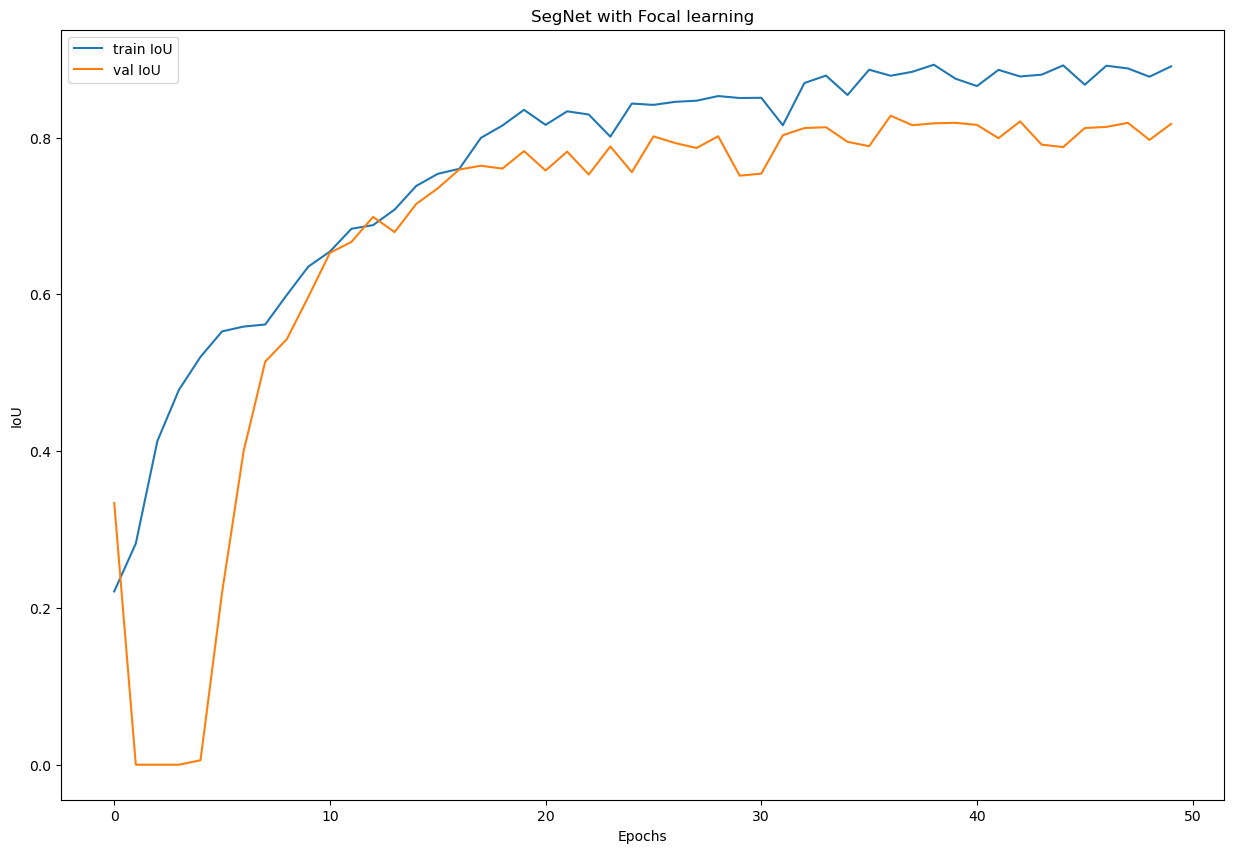

In [106]:
plt.figure(figsize=(15, 10))
plt.plot(seg_metricks3['train'])
plt.plot(seg_metricks3['val'])
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend(['train IoU','val IoU'])
plt.title('SegNet with Focal learning')
plt.show()

# Вывод:
    Так же как и с графиками поведения loss'a, здесь нет никаких аномалий.
        Модель спокойно(насколько это возможно для такой маленькой выборки)
        обучалась и повышала качество IoU метрики.Оставание val и test 
        показателей не критическое, переобучения нет.

# Оценим качество обучения моделей по их loss функции на Val выборке 

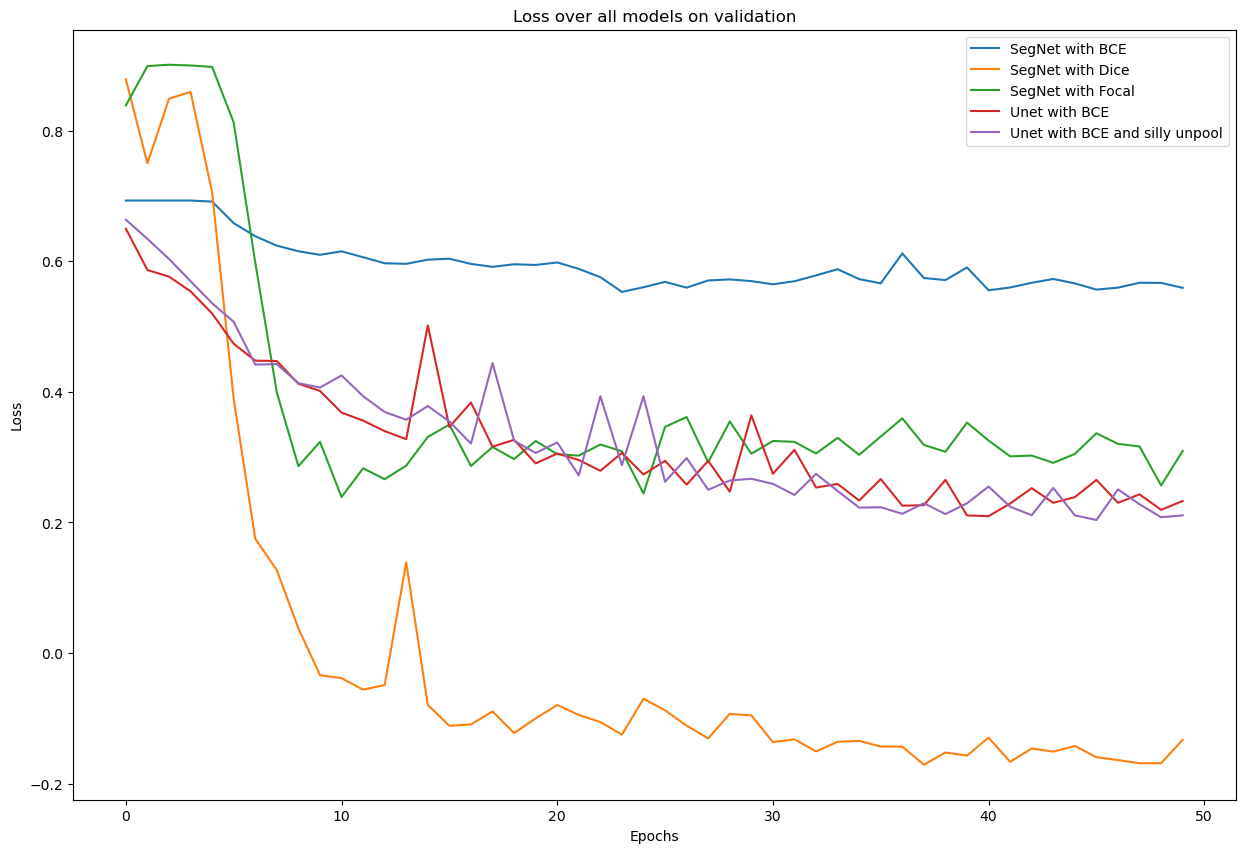

In [110]:
plt.figure(figsize=(15, 10))
plt.plot(seg_losses1['val'])
plt.plot(seg_losses2['val'])
plt.plot(seg_losses3['val'])
plt.plot(unet_losses1['val'])
plt.plot(unet_losses2['val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['SegNet with BCE','SegNet with Dice',
            'SegNet with Focal','Unet with BCE','Unet with BCE and silly unpool'])
plt.title('Loss over all models on validation')
plt.show()

# Вывод:
    Главное - не смотреть на уровень нахождения самой кривой, так как на 
        графике представленны разные лоссы и как следствие - они принимают
        разные значения .
    Главный признак качественного обучения здесь - это адекватность поведения
        самой кривой. В данном случае следует отметить хороший процесс 
        обучения у SegNet_Dice и Unet_BCE.

# Рассмотрим обучение SegNet_Dice внимательнее:

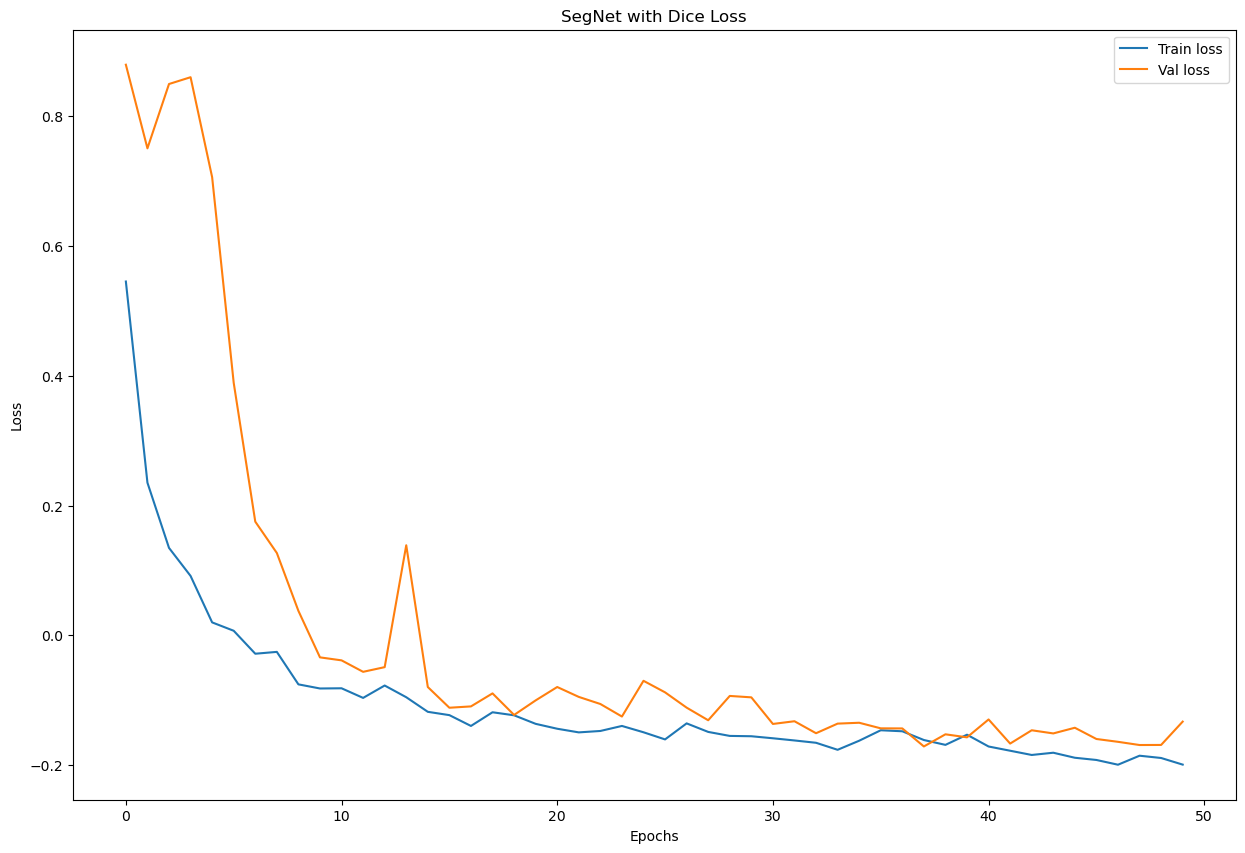

In [121]:
plt.figure(figsize=(15, 10))
plt.plot(seg_losses2['train'])
plt.plot(seg_losses2['val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss','Val loss'])
plt.title('SegNet with Dice Loss')
plt.show()

# Вывод: 
    Гармоничное обучение модели, лосс вышел на плато. 
    Переобучения не обнаружено

# Рассмотрим обучение Unet_BCE внимательнее:

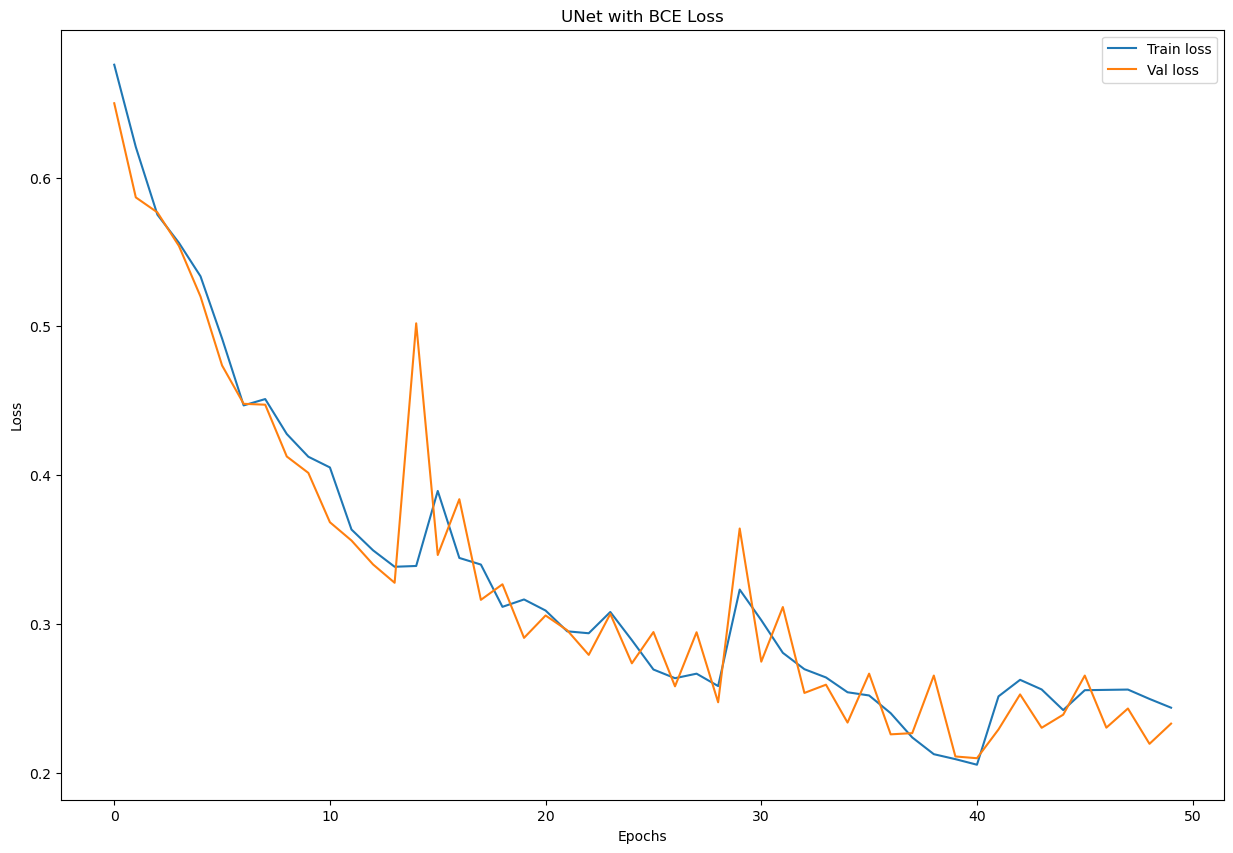

In [122]:
plt.figure(figsize=(15, 10))
plt.plot(unet_losses1['train'])
plt.plot(unet_losses1['val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train loss','Val loss'])
plt.title('UNet with BCE Loss')
plt.show()

# Вывод: 
    Как мы видим, обучение менее стабильное, за 50 эпох лосс
        не успел выйти на плато, однако кривые на train и val 
        хорошо повторяют друг дурга, что не может не радовать.

# =====Общий вывод=====
    Исследовав все полученные модели, поведение их метрик и функций потерь
        во время обучения и наконец оценив их IoU Score на test data,
        наилучшей можелью показала себя модель SegNet, обученная на Focal Loss
    Во-первых она отличается самым высоким скором IoU = 0.84
    Во-вторых имеет гладкую кривую лосса на val и train без явного переобучения
    В-третьих достигает плато(т.е. своего потенциала на этих данных)
    В-четвертых график поведения на IoU также выглядит симпотично